In [2]:
%%capture
!pip install wordcloud

#### Importing Libraries

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
%matplotlib inline
plt.style.use('bmh')

In [7]:
# self created packages
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.visualizations import Visualization

In [8]:
# pyspark packages
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, desc, year, month, explode, split
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, FloatType, BooleanType

#### Setting Spark Session and Loading Data

In [10]:
spark = SparkSession.builder \
    .appName("MIS548 Project") \
    .config("spark.sql.debug.maxToStringFields", "1000") \
    .getOrCreate()

spark

24/10/17 20:16:37 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [11]:
ip_data = spark.read.option("header", "True") \
                .option("inferSchema", "True") \
                .option("quote", '"') \
                .option("escape", '"') \
                .option("sep", ",") \
                .option("ignoreLeadingWhiteSpace", "True") \
                .option("ignoreTrailingWhiteSpace", "True") \
                .option("multiLine", "True") \
                .option("mode", "PERMISSIVE") \
                .csv("../data/gun-violence-data_01-2013_03-2018.csv")

# pandas_df = pd.read_csv("../data/gun-violence-data_01-2013_03-2018.csv")
# ip_data = spark.createDataFrame(pandas_df)
# ip_data = ip_data.drop('_c0')
print(f"Number of records in the data : {ip_data.count()}")
print(f"Number of columns: {len(ip_data.columns)}")

Number of records in the data : 239677
Number of columns: 29


In [12]:
ip_data = ip_data.dropDuplicates()

print("DataFrame after dropping duplicates:")
ip_data.count()

DataFrame after dropping duplicates:


239677

Noticed issue with reading data using PySpark, not sure how to tackle it. Need to figure out. Instead of address column something else is coming and not sure what the exact reason is.

And the data count is also having a mismatch. Some weird behaviour is happening.

The issue is that the data is having `\n` in the notes column and it is the root cause for the issue. Need to figure out a way to solve this. May be we can regenerate the input file after some datawranging done using pandas which supports it.

In [14]:
ip_data.printSchema()

root
 |-- incident_id: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- state: string (nullable = true)
 |-- city_or_county: string (nullable = true)
 |-- address: string (nullable = true)
 |-- n_killed: integer (nullable = true)
 |-- n_injured: integer (nullable = true)
 |-- incident_url: string (nullable = true)
 |-- source_url: string (nullable = true)
 |-- incident_url_fields_missing: boolean (nullable = true)
 |-- congressional_district: integer (nullable = true)
 |-- gun_stolen: string (nullable = true)
 |-- gun_type: string (nullable = true)
 |-- incident_characteristics: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- location_description: string (nullable = true)
 |-- longitude: double (nullable = true)
 |-- n_guns_involved: integer (nullable = true)
 |-- notes: string (nullable = true)
 |-- participant_age: string (nullable = true)
 |-- participant_age_group: string (nullable = true)
 |-- participant_gender: string (nullable = true)
 |-- 

**TO DO:**

All of the data types of the columns seems to be loaded as `string`, so we may need to convert the data types of our columns while reading the file.

#### Missing Values and Duplicate Data Check

In [17]:
def get_null_counts(df):
    total_rows = df.count()
    
    null_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])

    narrow_null_counts = null_counts.selectExpr(
                                    f"'{null_counts.columns[0]}' as column_name",
                                    f"{null_counts.columns[0]} as null_count",
                                    f"({null_counts.columns[0]} / {total_rows} * 100) as null_percentage")

    for c in null_counts.columns[1:]:
        next_col = null_counts.selectExpr(f"'{c}' as column_name", 
                                          f"{c} as null_count",
                                          f"({c} / {total_rows} * 100) as null_percentage")
        narrow_null_counts = narrow_null_counts.union(next_col)
    
    narrow_null_counts = narrow_null_counts.orderBy(desc("null_count"))
    
    return narrow_null_counts

In [18]:
narrow_null_counts = get_null_counts(ip_data)
narrow_null_counts.show(n=29, truncate=False)

+---------------------------+----------+-------------------+
|column_name                |null_count|null_percentage    |
+---------------------------+----------+-------------------+
|participant_relationship   |223903    |93.4186425898188   |
|location_description       |197588    |82.43928286819344  |
|participant_name           |122253    |51.00739745574252  |
|gun_stolen                 |99498     |41.51337007722894  |
|gun_type                   |99451     |41.493760352474375 |
|n_guns_involved            |99451     |41.493760352474375 |
|participant_age            |92298     |38.509327136104005 |
|notes                      |81017     |33.80257596682201  |
|participant_age_group      |42119     |17.573233977394576 |
|state_house_district       |38772     |16.17677123795775  |
|participant_gender         |36362     |15.171251309053435 |
|state_senate_district      |32335     |13.49107340295481  |
|participant_status         |27626     |11.526345873821851 |
|participant_type       

**Inference:**
Almost all the columns are having missing values. Some with signficant amount of missing values such as `participant_relationship`, `location_description`, `participant_name`, `n_guns_involved`, `gun_type`, `participant_age`, `gun_stolen`. From the above mentioned columns we might not use any of them for analysis except for `participant_age`, `n_guns_involved`, `gun_type`. So we might need to drop these columns instead of handling this missing data.

For the rest of the missing data we might need to handle those missing data.

**TO DO:**
1) We might need to drop the rows with missing information for the key columns such as `date`, `city_or_county`, `state` to allow for authenticity of the data. Instead of imputing the data.
2) We might impute for some columns with missing data and mention it clearly.
3) Or we might actually replace NA values with some key word such as `MISSING` or `UNKNOWN` for categorical data and `0` or other numeric values for the numerical data.


In [20]:
def check_duplicates_except(df, column_to_exclude=""):
    columns_to_check = [col for col in df.columns if col != column_to_exclude]
    
    df_duplicates = df.groupBy(columns_to_check).count().filter("count > 1")
    
    return df_duplicates

In [21]:
ip_data_dup_chk = check_duplicates_except(ip_data)

print(f"Number of Duplicate Rows: {ip_data_dup_chk.count()}")
#print(f"Frequency of the Duplicated Row: {ip_data_dup_chk.select('count').first()[0]}")

Number of Duplicate Rows: 0


**TO DO:**

The duplicate row is nothing but containing all `NULL` values in all columns.

#### Categorical Columns Analysis

By having an initial look at the data we can identify what are the categorical data columns and columns with string values we are having.

And we won't be analyzing few columns as they do not add much insights and we might drop those columns too.
The columns which we won't be using are:
`incident_id`, `incident_url`, `source_url`, `incident_url_fields_missing`, `location_description`, `participant_name`, `participant_relationship`, `sources`.

In [24]:
str_cols = ["state", "city_or_county", "address", "congressional_district", "gun_stolen",
            "gun_type", "incident_characteristics", "participant_age", "participant_age_group", 
            "participant_gender", "participant_status", "participant_type", "state_house_district", 
            "state_senate_district"]

In [25]:
def get_unq_val_cnts(df):
    for col in df.columns:
        unq_val = df.select(col).distinct().count()
        print(f"Total unique values in the column {col} : {unq_val}")

def get_most_freq(df):
    for col in df.columns:
        print(f"Top 5 frequent values for {col}:")
        df.groupBy(col).count().orderBy('count', ascending=False).show(5)

In [26]:
cat_ip_data = ip_data.select(*str_cols)
get_unq_val_cnts(cat_ip_data)

Total unique values in the column state : 51
Total unique values in the column city_or_county : 12821


Total unique values in the column address : 197116
Total unique values in the column congressional_district : 55
Total unique values in the column gun_stolen : 350
Total unique values in the column gun_type : 2503


Total unique values in the column incident_characteristics : 18127


Total unique values in the column participant_age : 18952


Total unique values in the column participant_age_group : 899
Total unique values in the column participant_gender : 874
Total unique values in the column participant_status : 2151
Total unique values in the column participant_type : 260
Total unique values in the column state_house_district : 276
Total unique values in the column state_senate_district : 69


In [27]:
get_most_freq(cat_ip_data)

Top 5 frequent values for state:


+----------+-----+
|     state|count|
+----------+-----+
|  Illinois|17556|
|California|16306|
|   Florida|15029|
|     Texas|13577|
|      Ohio|10244|
+----------+-----+
only showing top 5 rows

Top 5 frequent values for city_or_county:


+--------------+-----+
|city_or_county|count|
+--------------+-----+
|       Chicago|10814|
|     Baltimore| 3943|
|    Washington| 3279|
|   New Orleans| 3084|
|  Philadelphia| 2963|
+--------------+-----+
only showing top 5 rows

Top 5 frequent values for address:


+--------------------+-----+
|             address|count|
+--------------------+-----+
|                NULL|16497|
|2375 Internationa...|  160|
|6000 N Terminal Pkwy|  141|
|         Main Street|  139|
|3400 E Sky Harbor...|  127|
+--------------------+-----+
only showing top 5 rows

Top 5 frequent values for congressional_district:


+----------------------+-----+
|congressional_district|count|
+----------------------+-----+
|                     1|36910|
|                     2|26945|
|                     3|20621|
|                     7|19709|
|                     4|18469|
+----------------------+-----+
only showing top 5 rows

Top 5 frequent values for gun_stolen:


+--------------------+------+
|          gun_stolen| count|
+--------------------+------+
|          0::Unknown|121310|
|                NULL| 99498|
|0::Unknown||1::Un...|  6116|
|           0::Stolen|  4503|
|0::Unknown||1::Un...|  1484|
+--------------------+------+
only showing top 5 rows

Top 5 frequent values for gun_type:


+--------------------+-----+
|            gun_type|count|
+--------------------+-----+
|                NULL|99451|
|          0::Unknown|93559|
|          0::Handgun|13018|
|              0::9mm| 4599|
|0::Unknown||1::Un...| 2410|
+--------------------+-----+
only showing top 5 rows

Top 5 frequent values for incident_characteristics:


+------------------------+-----+
|incident_characteristics|count|
+------------------------+-----+
|    Shot - Wounded/In...|47541|
|    Shot - Dead (murd...|23019|
|    Shots Fired - No ...|15690|
|    Shot - Wounded/In...| 5121|
|    Armed robbery wit...| 3438|
+------------------------+-----+
only showing top 5 rows

Top 5 frequent values for participant_age:


+---------------+-----+
|participant_age|count|
+---------------+-----+
|           NULL|92298|
|          0::24| 3814|
|          0::23| 3735|
|          0::22| 3733|
|          0::19| 3719|
+---------------+-----+
only showing top 5 rows

Top 5 frequent values for participant_age_group:


+---------------------+-----+
|participant_age_group|count|
+---------------------+-----+
|         0::Adult 18+|94671|
| 0::Adult 18+||1::...|49273|
|                 NULL|42119|
| 0::Adult 18+||1::...|13893|
|        0::Teen 12-17| 7392|
+---------------------+-----+
only showing top 5 rows

Top 5 frequent values for participant_gender:


+--------------------+-----+
|  participant_gender|count|
+--------------------+-----+
|             0::Male|93496|
|    0::Male||1::Male|43530|
|                NULL|36362|
|0::Male||1::Male|...|12383|
|  0::Female||1::Male|10602|
+--------------------+-----+
only showing top 5 rows

Top 5 frequent values for participant_status:


+--------------------+-----+
|  participant_status|count|
+--------------------+-----+
|          0::Injured|42293|
|                NULL|27626|
|0::Unharmed, Arre...|25746|
|           0::Killed|21216|
|0::Injured||1::Un...|12680|
+--------------------+-----+
only showing top 5 rows

Top 5 frequent values for participant_type:


+--------------------+-----+
|    participant_type|count|
+--------------------+-----+
|           0::Victim|58564|
|0::Victim||1::Sub...|50579|
|  0::Subject-Suspect|44914|
|                NULL|24863|
|0::Victim||1::Sub...|10941|
+--------------------+-----+
only showing top 5 rows

Top 5 frequent values for state_house_district:


+--------------------+-----+
|state_house_district|count|
+--------------------+-----+
|                NULL|38772|
|                  18| 3476|
|                  10| 3411|
|                  32| 3218|
|                  31| 3192|
+--------------------+-----+
only showing top 5 rows

Top 5 frequent values for state_senate_district:


+---------------------+-----+
|state_senate_district|count|
+---------------------+-----+
|                 NULL|32335|
|                    5|10041|
|                    9| 7963|
|                    3| 7837|
|                    4| 7328|
+---------------------+-----+
only showing top 5 rows



**Inference**
We can notice that the most of the data needs to be cleaned as there is a lot bad data such as in `address` column. Even in other columns such as `participant_type`, `participant_status`. All of these columns have this prefiz `number::` which needs to be handled. Needs a more clear analysis on `incident_characterstics`.

**TO DO**
Clean whole data with bad data as mentioned above.

In [29]:
cat_ip_data.groupBy("incident_characteristics").count().orderBy("count", ascending=False).show(10, truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------+-----+
|incident_characteristics                                                                                                             |count|
+-------------------------------------------------------------------------------------------------------------------------------------+-----+
|Shot - Wounded/Injured                                                                                                               |47541|
|Shot - Dead (murder, accidental, suicide)                                                                                            |23019|
|Shots Fired - No Injuries                                                                                                            |15690|
|Shot - Wounded/Injured||Drive-by (car to street, car to car)                                                                         |5121 |
|Armed

**TO DO**

Handle null values, Remove or standardize delimiters, standardize the text, handling spelling mistakes and synonyms, removing irrelevant characteristics

##### Visualizations

In [32]:
visualization = Visualization(ip_data.toPandas())

In [33]:
categorical_cols = ["state", "city_or_county", "address", "congressional_district",
            "gun_type", "participant_age", "participant_gender", "state_house_district", "state_senate_district"]

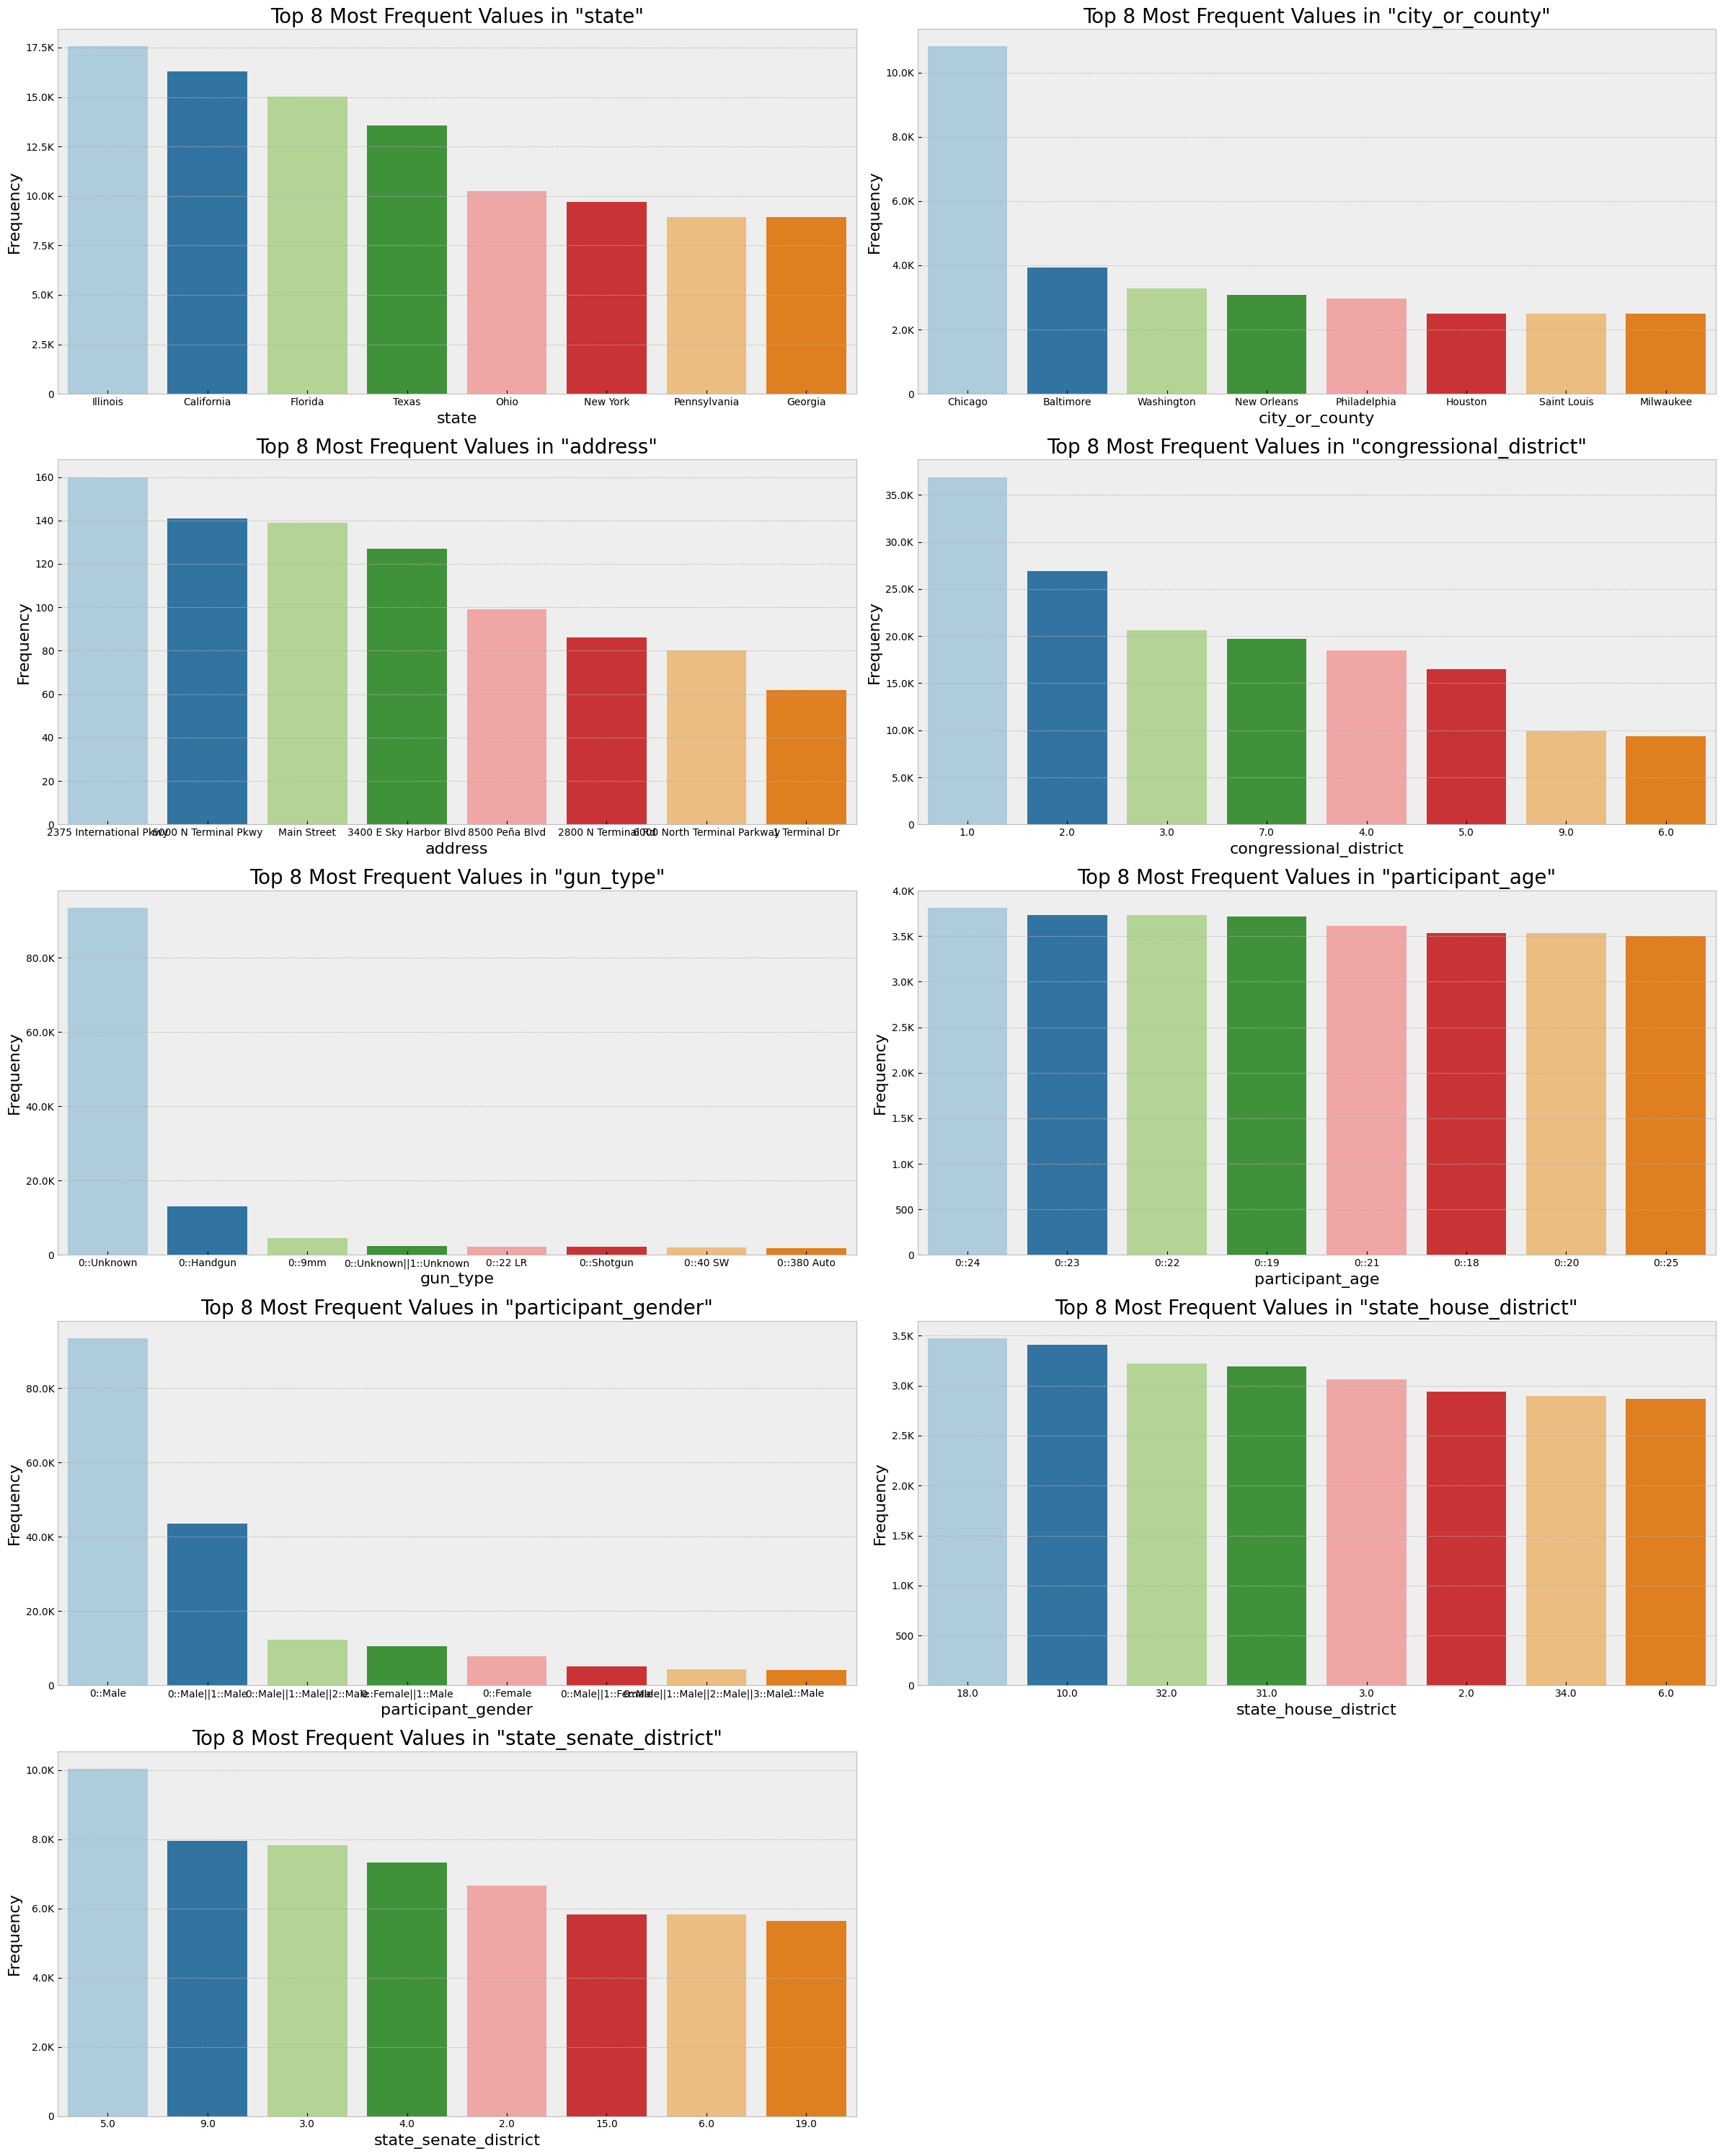

In [118]:
visualization.combined_plot(categorical_cols, visualization.bar_plot, fig_size=(24, 30))

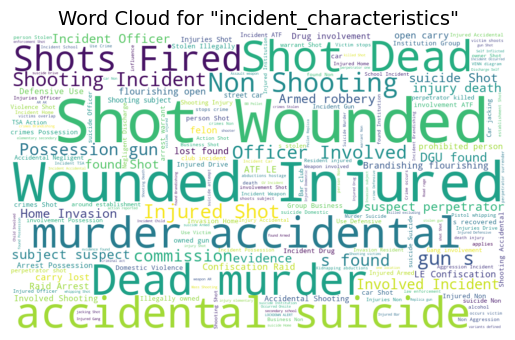

In [35]:
visualization.word_cloud(plt.gca(), 'incident_characteristics')

**Inference:**



#### Numerical Columns Analysis

In [37]:
num_cols = ["n_killed", "n_injured", "n_guns_involved"]

In [38]:
num_ip_data = ip_data.select(*num_cols)
get_unq_val_cnts(num_ip_data)

Total unique values in the column n_killed : 16
Total unique values in the column n_injured : 23
Total unique values in the column n_guns_involved : 107


In [39]:
get_most_freq(num_ip_data)

Top 5 frequent values for n_killed:


+--------+------+
|n_killed| count|
+--------+------+
|       0|185835|
|       1| 48436|
|       2|  4604|
|       3|   595|
|       4|   139|
+--------+------+
only showing top 5 rows

Top 5 frequent values for n_injured:


+---------+------+
|n_injured| count|
+---------+------+
|        0|142487|
|        1| 81986|
|        2| 11484|
|        3|  2513|
|        4|   760|
+---------+------+
only showing top 5 rows

Top 5 frequent values for n_guns_involved:


+---------------+------+
|n_guns_involved| count|
+---------------+------+
|              1|127548|
|           NULL| 99451|
|              2|  7477|
|              3|  2021|
|              4|   871|
+---------------+------+
only showing top 5 rows



In [40]:
num_ip_data.select(num_cols).describe().show()

+-------+-------------------+------------------+------------------+
|summary|           n_killed|         n_injured|   n_guns_involved|
+-------+-------------------+------------------+------------------+
|  count|             239677|            239677|            140226|
|   mean|0.25228953967214207|0.4940065171042695|1.3724416299402393|
| stddev|  0.521778872980877|0.7299522740856977| 4.678202195047604|
|    min|                  0|                 0|                 1|
|    max|                 50|                53|               400|
+-------+-------------------+------------------+------------------+



**TO DO**

Need to handle missing data, rest seems to be alright.

In [42]:
aggregated_df = ip_data.groupBy("state") \
                        .agg(sum("n_killed").alias("total_killed"), 
                            sum("n_injured").alias("total_injured"))

aggregated_df.orderBy("total_killed", ascending=False).show(truncate=False)

+--------------+------------+-------------+
|state         |total_killed|total_injured|
+--------------+------------+-------------+
|California    |5562        |7644         |
|Texas         |5046        |6106         |
|Florida       |3909        |7072         |
|Illinois      |3409        |13514        |
|Ohio          |2508        |5703         |
|Georgia       |2456        |4056         |
|Pennsylvania  |2395        |5056         |
|North Carolina|2225        |4629         |
|Louisiana     |2179        |4398         |
|Missouri      |2136        |3585         |
|Alabama       |1880        |2998         |
|Tennessee     |1824        |4478         |
|New York      |1705        |5059         |
|Maryland      |1691        |3167         |
|South Carolina|1610        |3084         |
|Indiana       |1608        |2956         |
|Michigan      |1588        |2990         |
|Virginia      |1459        |3566         |
|Mississippi   |1176        |1883         |
|New Jersey    |1168        |254

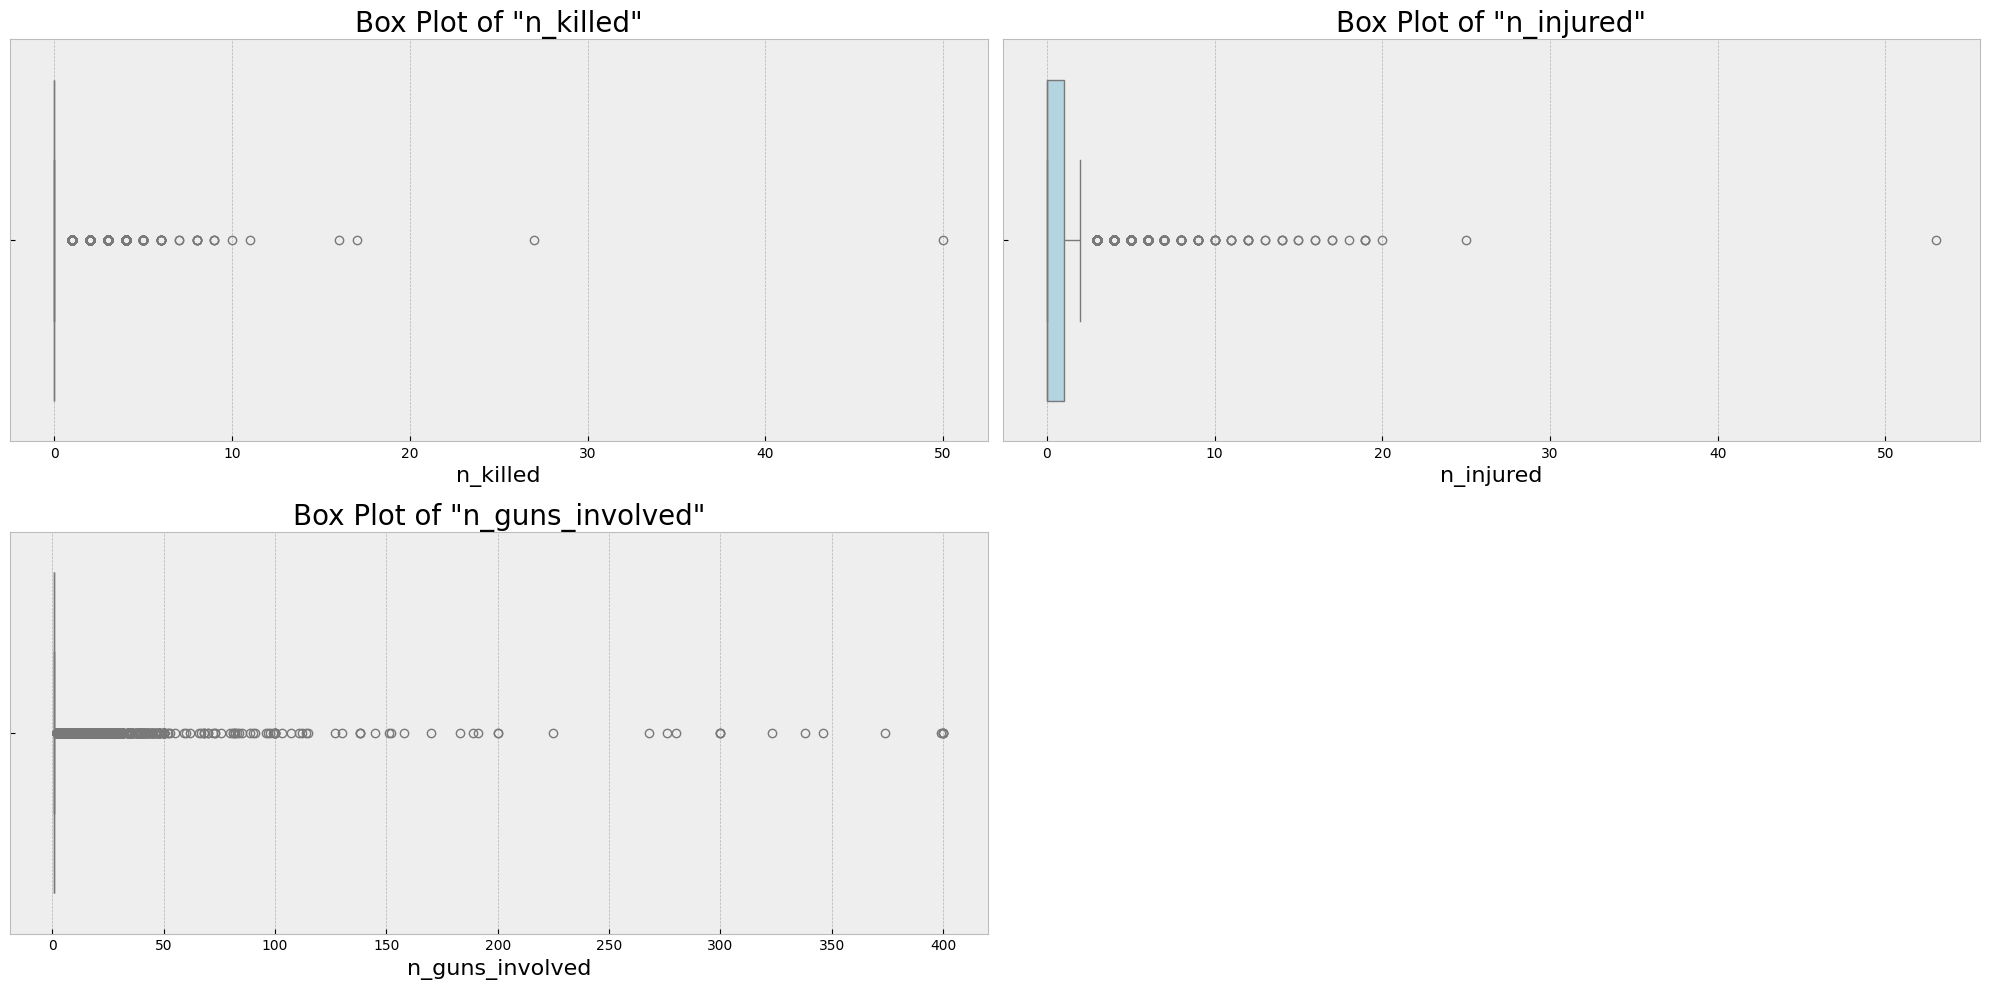

In [43]:
visualization.combined_plot(num_cols, visualization.box_plot, fig_size=(20, 10))

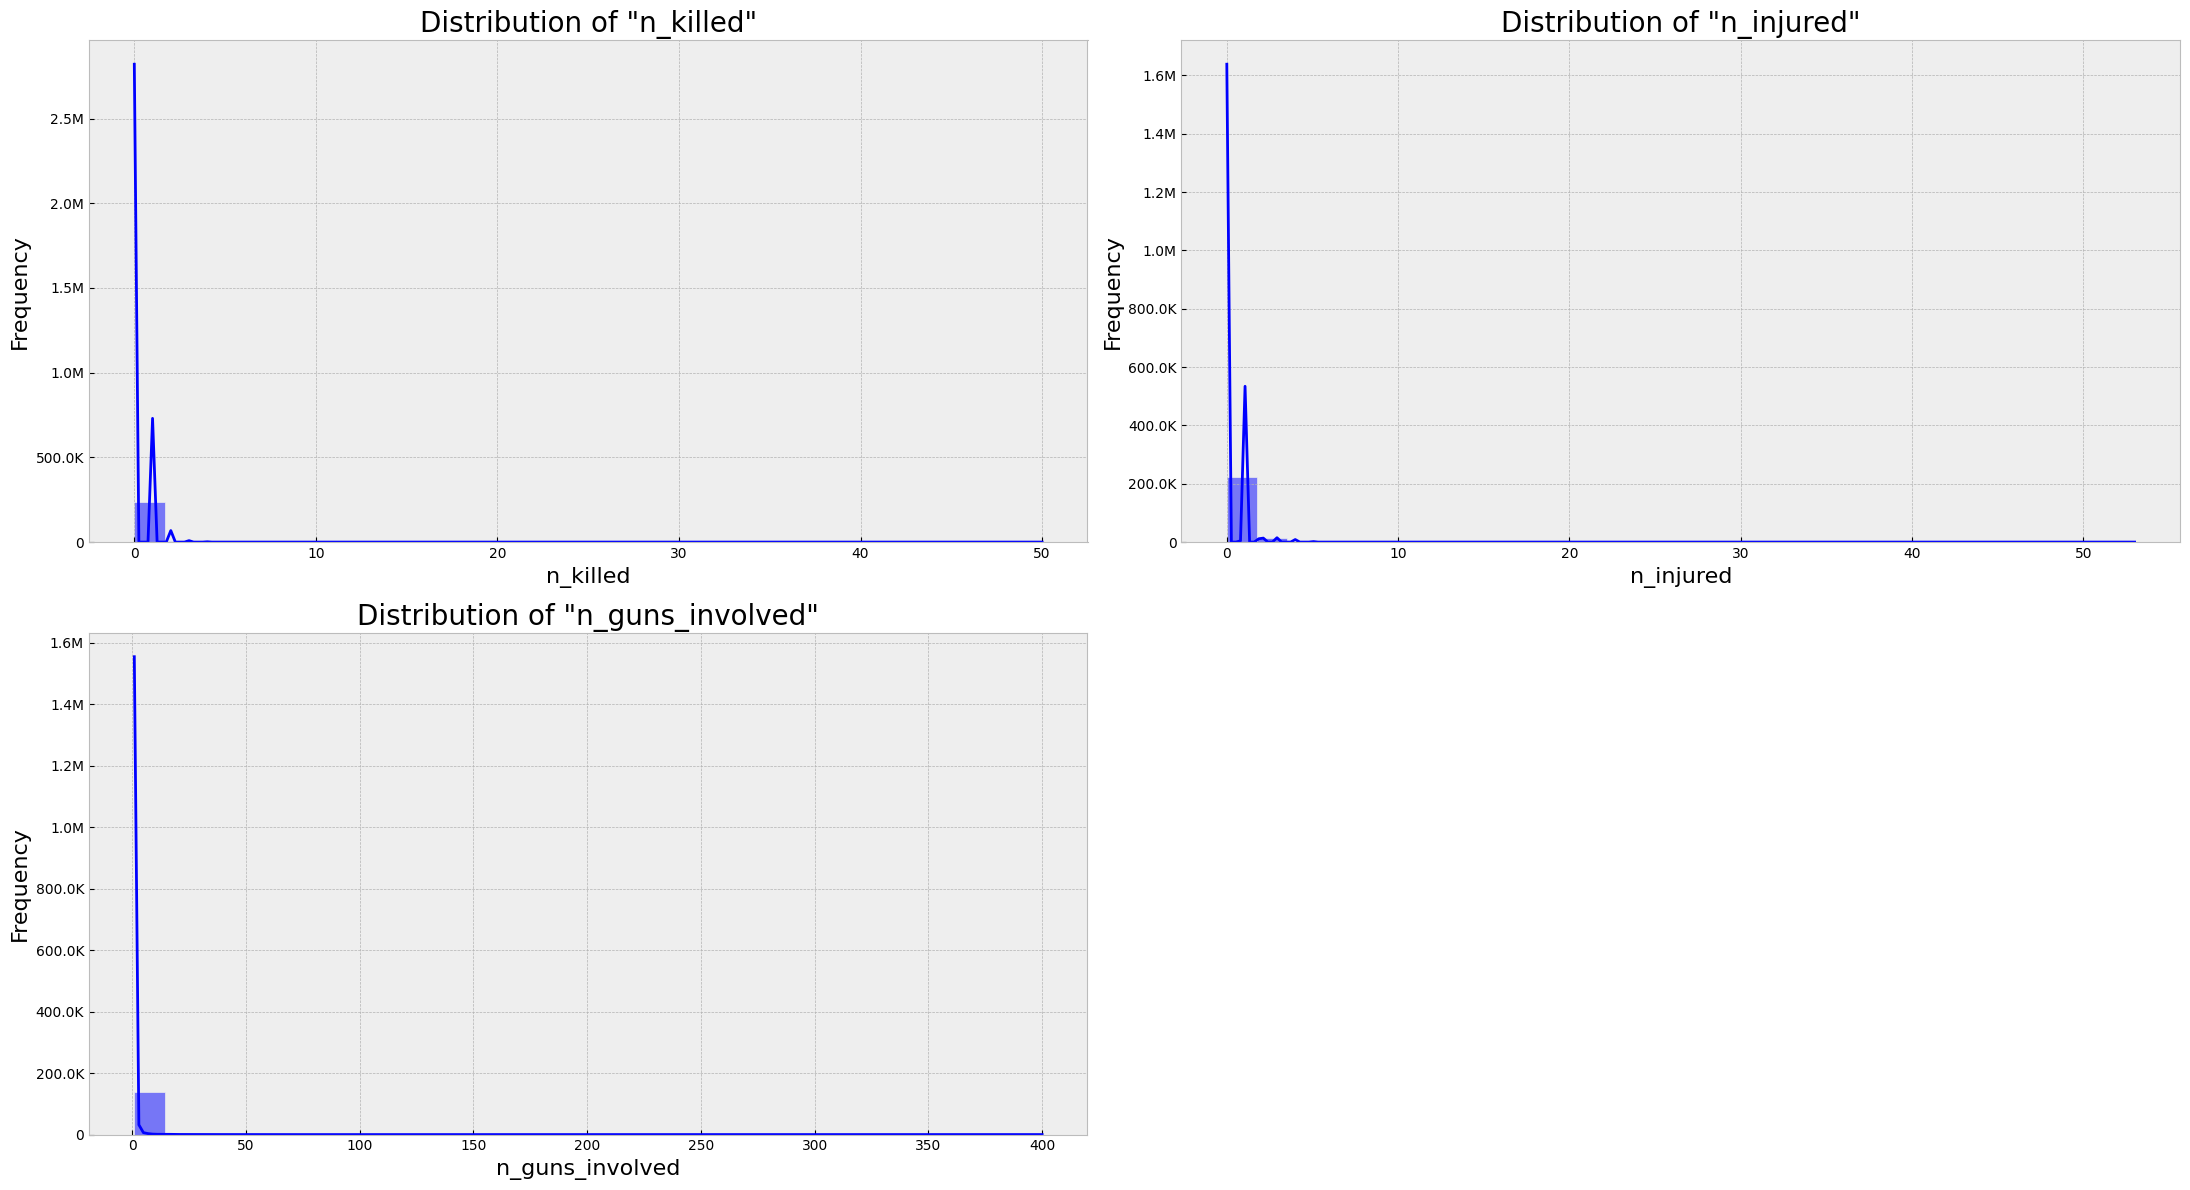

In [44]:
visualization.combined_plot(num_cols, visualization.dist_plot, fig_size=(22, 12))

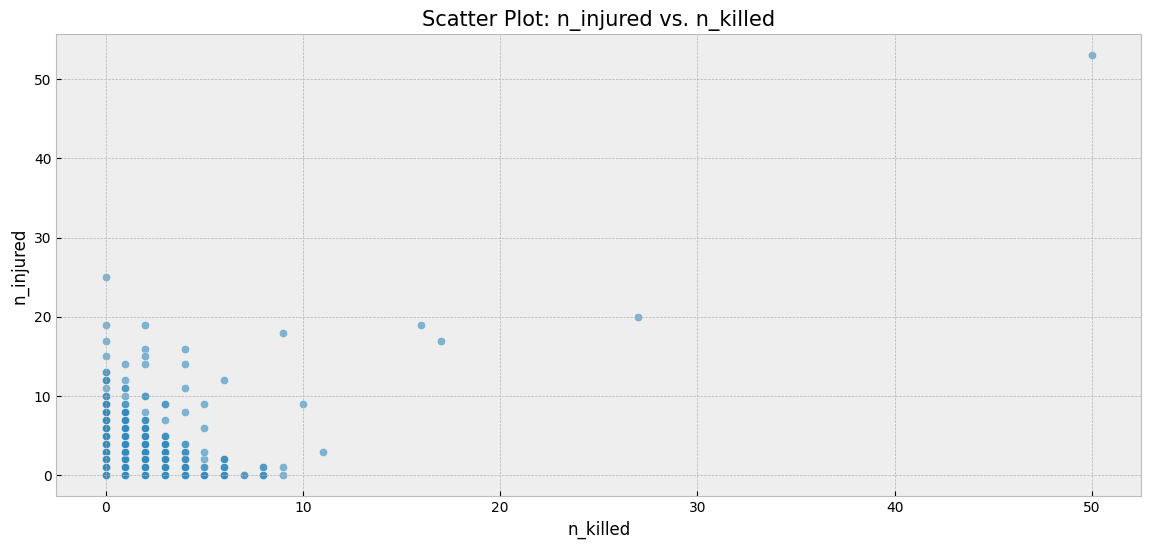

In [45]:
scatter_col_x = 'n_killed'
scatter_col_y = 'n_injured'
fig, ax = plt.subplots(figsize=(14, 6))
visualization.scatter_plot(ax, scatter_col_x, scatter_col_y)

**Inference:**



#### Date Columns Analysis

In [47]:
date_cols = ["date"]

In [48]:
date_ip_data = ip_data.select(*date_cols)
get_unq_val_cnts(date_ip_data)

Total unique values in the column date : 1725


In [49]:
get_most_freq(date_ip_data)

Top 5 frequent values for date:


+----------+-----+
|      date|count|
+----------+-----+
|2017-01-01|  342|
|2017-07-04|  248|
|2017-05-28|  242|
|2018-01-01|  242|
|2016-08-28|  230|
+----------+-----+
only showing top 5 rows



In [50]:
date_ip_data.withColumn("year", year(date_ip_data["date"])).groupBy("year").count().orderBy("count", ascending=False).show()

+----+-----+
|year|count|
+----+-----+
|2017|61401|
|2016|58763|
|2015|53579|
|2014|51854|
|2018|13802|
|2013|  278|
+----+-----+



In [51]:
yearly_df = ip_data.withColumn("year", year(col("date"))) \
                    .groupBy("year") \
                    .agg(sum("n_killed").alias("total_killed"),
                        sum("n_injured").alias("total_injured"))

yearly_df.orderBy("year", ascending=False).show(truncate=False)

+----+------------+-------------+
|year|total_killed|total_injured|
+----+------------+-------------+
|2018|3533        |6171         |
|2017|15511       |30703        |
|2016|15066       |30580        |
|2015|13484       |26967        |
|2014|12557       |23002        |
|2013|317         |979          |
+----+------------+-------------+



In [52]:
yearly_state_df = ip_data.withColumn("year", year(col("date"))) \
                        .groupBy("year", "state") \
                        .agg(sum("n_killed").alias("total_killed"),
                            sum("n_injured").alias("total_injured")) \
                        .orderBy("year", "state", ascending=False)

yearly_state_df.show(truncate=False)

+----+--------------+------------+-------------+
|year|state         |total_killed|total_injured|
+----+--------------+------------+-------------+
|2018|Wyoming       |10          |0            |
|2018|Wisconsin     |46          |118          |
|2018|West Virginia |23          |34           |
|2018|Washington    |54          |83           |
|2018|Virginia      |72          |187          |
|2018|Vermont       |4           |3            |
|2018|Utah          |10          |33           |
|2018|Texas         |310         |374          |
|2018|Tennessee     |98          |210          |
|2018|South Dakota  |7           |13           |
|2018|South Carolina|89          |192          |
|2018|Rhode Island  |5           |13           |
|2018|Pennsylvania  |136         |238          |
|2018|Oregon        |31          |39           |
|2018|Oklahoma      |44          |92           |
|2018|Ohio          |139         |277          |
|2018|North Dakota  |3           |7            |
|2018|North Carolina

**TO DO**



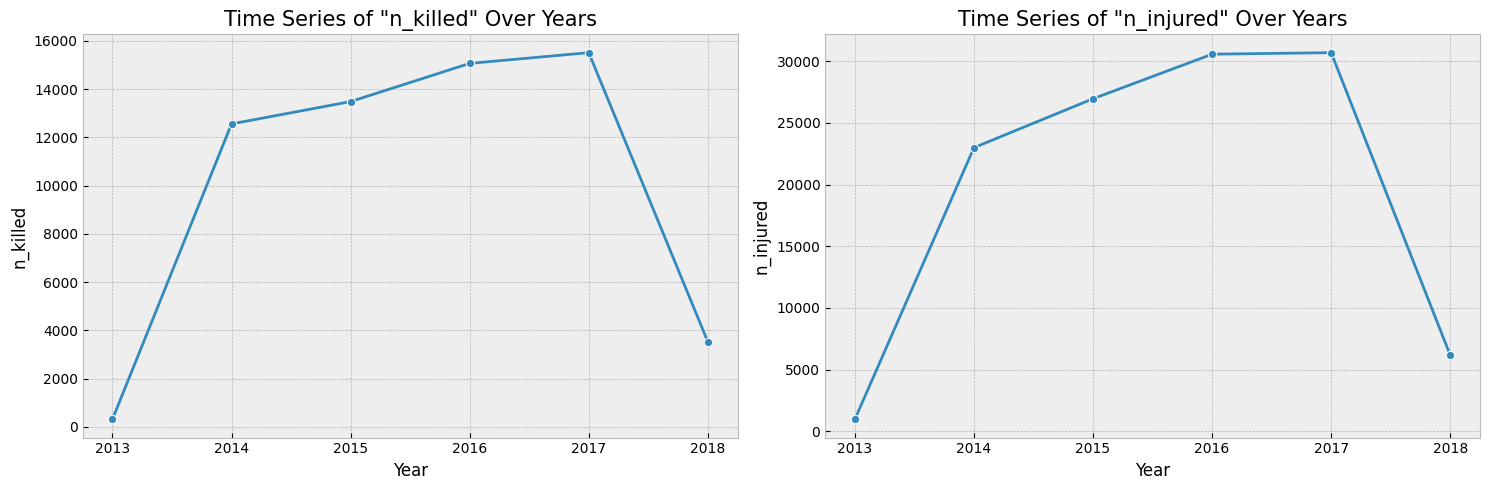

In [54]:
visualization.time_series_plot('date', ['n_killed', 'n_injured'], fig_size=(15, 5))

**Inference:**

#### Text Columns Analysis

In [56]:
txt_cols = ["notes"]

In [57]:
words_df = ip_data.withColumn("word", explode(split(col("notes"), "\\s+"))) \
    .groupBy("word") \
    .count() \
    .orderBy("count", ascending=False)

words_df.show(20, truncate=False)

+-----+-----+
|word |count|
+-----+-----+
|in   |46359|
|shot |41620|
|and  |24733|
|at   |24594|
|of   |18313|
|to   |17621|
|with |16191|
|fired|14698|
|man  |13885|
|shots|13317|
|gun  |12313|
|on   |12063|
|found|11821|
|by   |11579|
|1    |11227|
|a    |10938|
|Man  |10559|
|2    |10118|
|from |8519 |
|near |8467 |
+-----+-----+
only showing top 20 rows



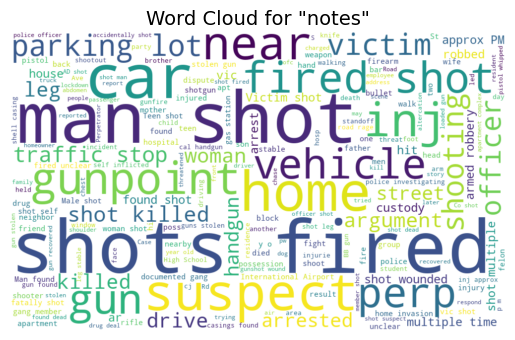

In [58]:
visualization.word_cloud(plt.gca(), 'notes')

**TO DO**

Update visualizations to make it look good. Try to add more insights as well on other data.